# Testing HW equilibrium

- Initial population: 7000
- Fertility rate: 2.0
- Replicates per scenario: 30
- Random mating parameters being explored: 1, 0.7, 0
- No restrictions for mating (siblings, cousins could mate), except for having different gender and being in reproduction time (15 to 50 years old)

In [2]:
library(data.table)
library(lfa)
library(ggplot2)
library(patchwork)
library(HardyWeinberg)
output_path = "../output/data/"
nrep = 30

In [14]:
# read data
dat = fread(paste0(output_path, "agents-snp-hw.csv"))
params = fread(paste0(output_path, "param-snp-hw.csv"))
rr = fread(paste0(output_path, "results-snp-hw.csv"))
# create id
dat[, id := .GRP, .(iteration, replicate)]


In [18]:
# final population
summary(rr$population)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   9300   13987   17546   18552   21526   38078 

In [19]:
# snp text to numeric
vars = paste0("snp", 0:99)
dat[, agent_id := 1:.N]
dat[, (vars) := tstrsplit(snps, ",", fixed=TRUE)]
dat[, (vars) := lapply(.SD, function(x) factor(as.numeric(gsub(".+=|\\}", "", x)), levels = 0:2)), .SDcols = vars]
df = merge(dat, params[, .(iteration, replicate, random_mating)], by = c("iteration", "replicate"))
rr = merge(rr, params[, .(iteration, replicate, random_mating)], by = c("iteration", "replicate"))

In [21]:
# testing transformation from snp text to columns
ss = sample(nrow(dat), 1)
dat[ss, snps]
dat[ss, ..vars]

[1] "{0=2.0, 1=1.0, 2=2.0, 3=1.0, 4=0.0, 5=1.0, 6=1.0, 7=2.0, 8=1.0, 9=0.0, 10=0.0, 11=1.0, 12=0.0, 13=1.0, 14=1.0, 15=1.0, 16=1.0, 17=2.0, 18=2.0, 19=0.0, 20=2.0, 21=2.0, 22=0.0, 23=0.0, 24=0.0, 25=0.0, 26=1.0, 27=1.0, 28=2.0, 29=0.0, 30=1.0, 31=0.0, 32=2.0, 33=0.0, 34=2.0, 35=0.0, 36=1.0, 37=2.0, 38=1.0, 39=2.0, 40=1.0, 41=0.0, 42=1.0, 43=0.0, 44=1.0, 45=2.0, 46=1.0, 47=2.0, 48=2.0, 49=2.0, 50=0.0, 51=1.0, 52=0.0, 53=1.0, 54=1.0, 55=1.0, 56=2.0, 57=1.0, 58=1.0, 59=0.0, 60=0.0, 61=1.0, 62=0.0, 63=1.0, 64=1.0, 65=0.0, 66=1.0, 67=1.0, 68=1.0, 69=2.0, 70=2.0, 71=0.0, 72=0.0, 73=1.0, 74=2.0, 75=0.0, 76=0.0, 77=0.0, 78=1.0, 79=0.0, 80=0.0, 81=1.0, 82=0.0, 83=2.0, 84=1.0, 85=1.0, 86=1.0, 87=1.0, 88=0.0, 89=1.0, 90=1.0, 91=1.0, 92=0.0, 93=0.0, 94=1.0, 95=2.0, 96=0.0, 97=0.0, 98=0.0, 99=1.0}"

snp0,snp1,snp2,snp3,snp4,snp5,snp6,snp7,snp8,snp9,...,snp90,snp91,snp92,snp93,snp94,snp95,snp96,snp97,snp98,snp99
<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,...,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
2,1,2,1,0,1,1,2,1,0,...,1,1,0,0,1,2,0,0,0,1


In [22]:

# standard function to test HW
getHWsnps = function(data, idvar = "id", snps = paste0("snp", 0:99)) {
    ids = unique(data[[idvar]])
    pvalues = NULL
    for (i in ids) {
        temp = copy(data[id == i])
        for (ii in snps) {
            t = table(temp[, get(ii)])
            allele = c("AA", "AB", "BB")
            t = as.vector(t)
            names(t) = allele
            pvalues = c(pvalues, HWChisq(t, verbose = FALSE)$pval)
        }
    }
    return(pvalues)
}

# This function is computationally expensive
getHWpvalues = function(data, idvar = "id", k = 1, nsample = NULL) {
    ids = unique(data[[idvar]])
    pvalues = NULL
    vars = names(data)[grepl("^snp[0-9]+$", names(data))] 
    for (i in ids) {
        temp = copy(data[id == i, ..vars])
        m = as.matrix(transpose(temp))
        # use k=1 for standard HW test
        LF = lfa(m, k)
        pvalues = c(pvalues, sHWE(m, LF, 4))
    }
    print(summary(pvalues))
    return(pvalues)
}

# Assortative mating (BMI)

When `random_mating == 1`, the BMI correlation between couples is around 0, while when `random_mating == 0` the correlation is about 0.80. This part of the model seems fine.

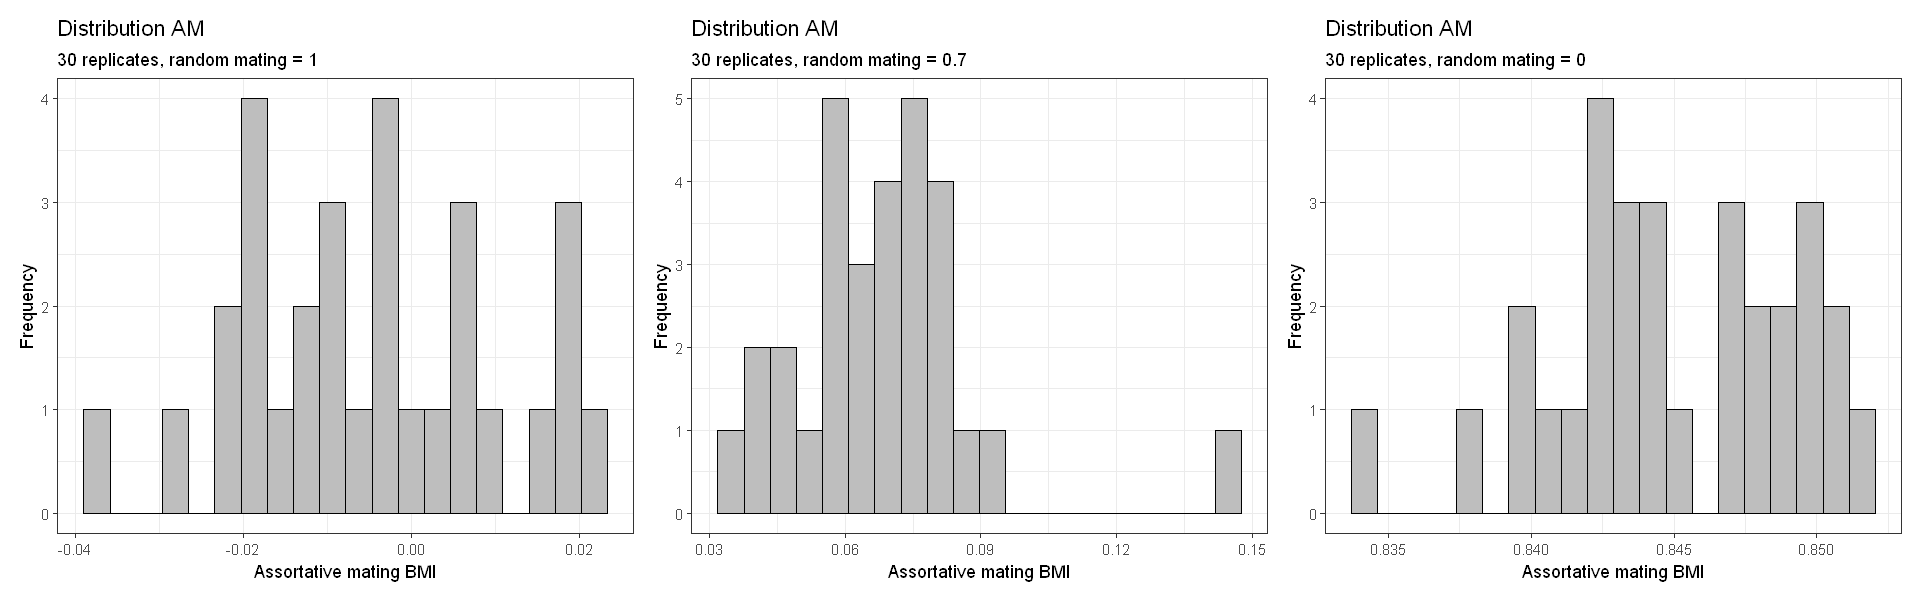

In [23]:
options(repr.plot.width=16, repr.plot.height=5)
plots = list() 
values = c(1, 0.7, 0)
for (i in 1:3) {
plots[[i]] = ggplot(rr[random_mating == values[i], .(am_bmi)], aes(am_bmi)) + 
    geom_histogram(bins = 20, fill="grey", colour="black") + theme_bw() + 
    labs(x = "Assortative mating BMI", y = "Frequency", 
    title = "Distribution AM", 
        subtitle = paste0(nrep, " replicates, random mating = ", values[i]))
}
wrap_plots(plots)

# Contrasting generation 0 and 100

Here we explore the distribution of p-values by SNPs for generation 0 and 100. 
After 100 generations, even  when `random_mating=1`, the distribution seems a bit skew towards 0. 

In [24]:
# get pvalues
pvalues0rm0 = getHWsnps(df[generation == 0 &  random_mating == 0])
pvalues100rm0 = getHWsnps(df[generation == 100 &  random_mating == 0])
pvalues0rm07 = getHWsnps(df[generation == 0 &  random_mating == 0.7])
pvalues100rm07 = getHWsnps(df[generation == 100 &  random_mating == 0.7])
pvalues0rm1 = getHWsnps(df[generation == 0 &  random_mating == 1])
pvalues100rm1 = getHWsnps(df[generation == 100 &  random_mating == 1])

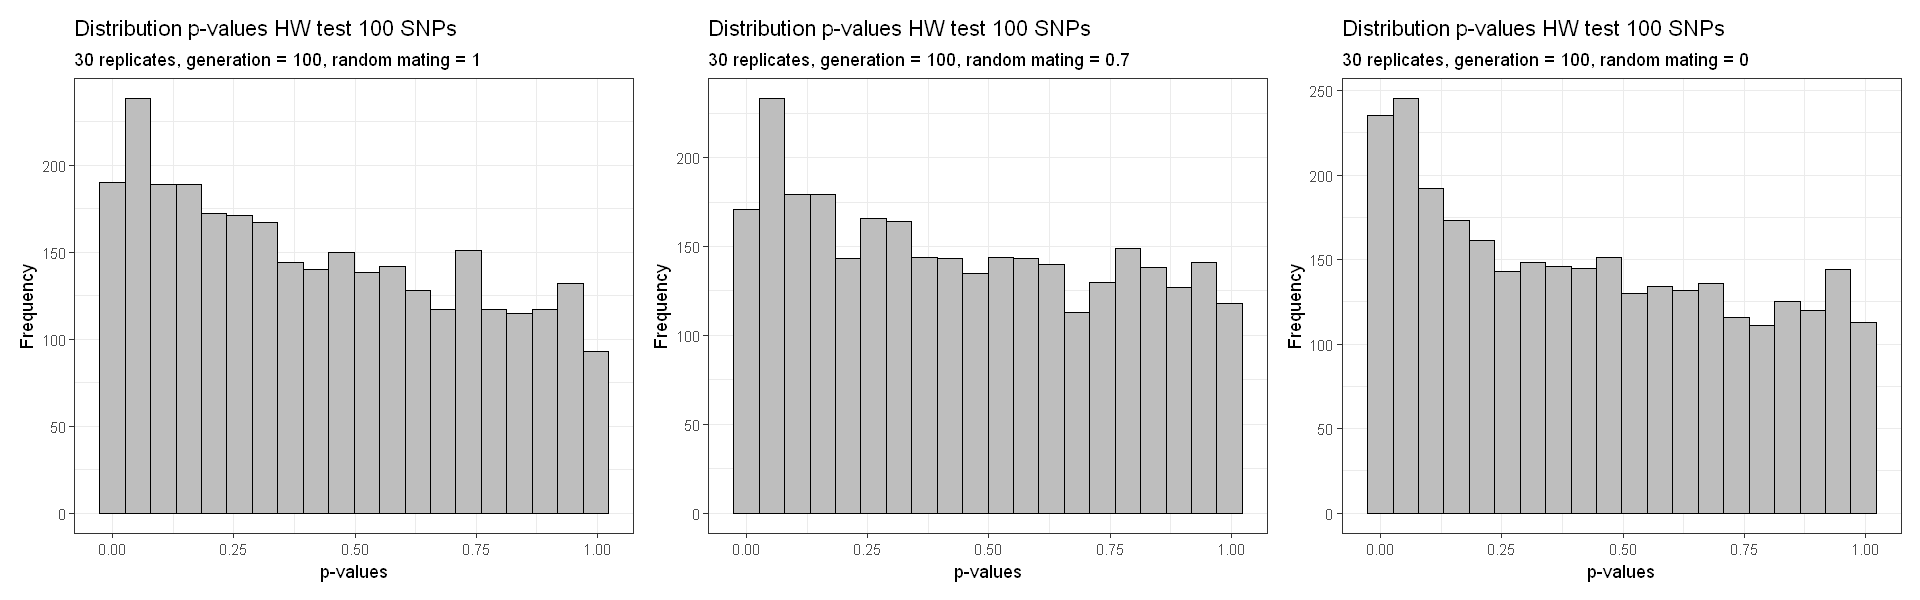

In [25]:
plots = list() 
vars = c("pvalues100rm1", "pvalues100rm07", "pvalues100rm0") 
values =  c(1, 0.7, 0)
for (i in 1:3) {
plots[[i]] = ggplot(data.table(pvalues = get(vars[i])), aes(pvalues)) + 
    geom_histogram(bins = 20, fill="grey", colour="black") + theme_bw() + 
    labs(x = "p-values", y = "Frequency", 
        title = "Distribution p-values HW test 100 SNPs", 
        subtitle = paste0(nrep, " replicates, generation = 100, random mating = ", values[i]))
}
wrap_plots(plots)

- With complete assortative mating, after 100 generation, the distribution seems to be closer to zero 
- The issue is that even when mating is completely at random (expect for gender and reproductive time), the distribution is skew toward lower values.
- Generation 0 looks fine, mostly uniform p-values.

It might be due to how fertility is implemented or the life cycle of agents (reproductive age), or sample size.

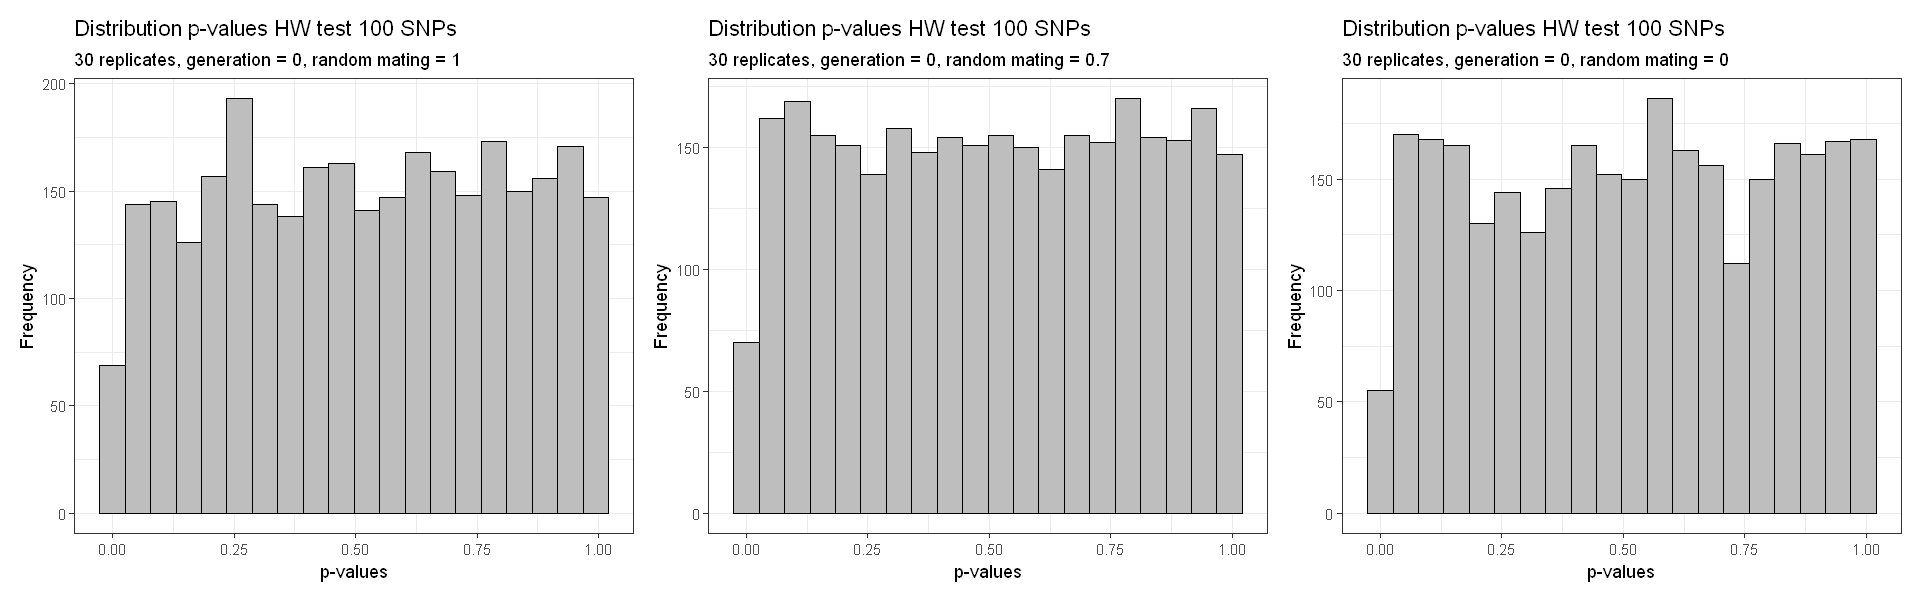

In [26]:
plots = list() 
vars = c("pvalues0rm1", "pvalues0rm07", "pvalues0rm0") 
values =  c(1, 0.7, 0)
for (i in 1:3) {
plots[[i]] = ggplot(data.table(pvalues = get(vars[i])), aes(pvalues)) + 
    geom_histogram(bins = 20, fill="grey", colour="black") + theme_bw() + 
    labs(x = "p-values", y = "Frequency", 
        title = "Distribution p-values HW test 100 SNPs", 
        subtitle = paste0(nrep, " replicates, generation = 0, random mating = ", values[i]))
}
wrap_plots(plots)